**Objective:**
Recreate the heatmap and dashboard as in the below image using Altair and Panel.

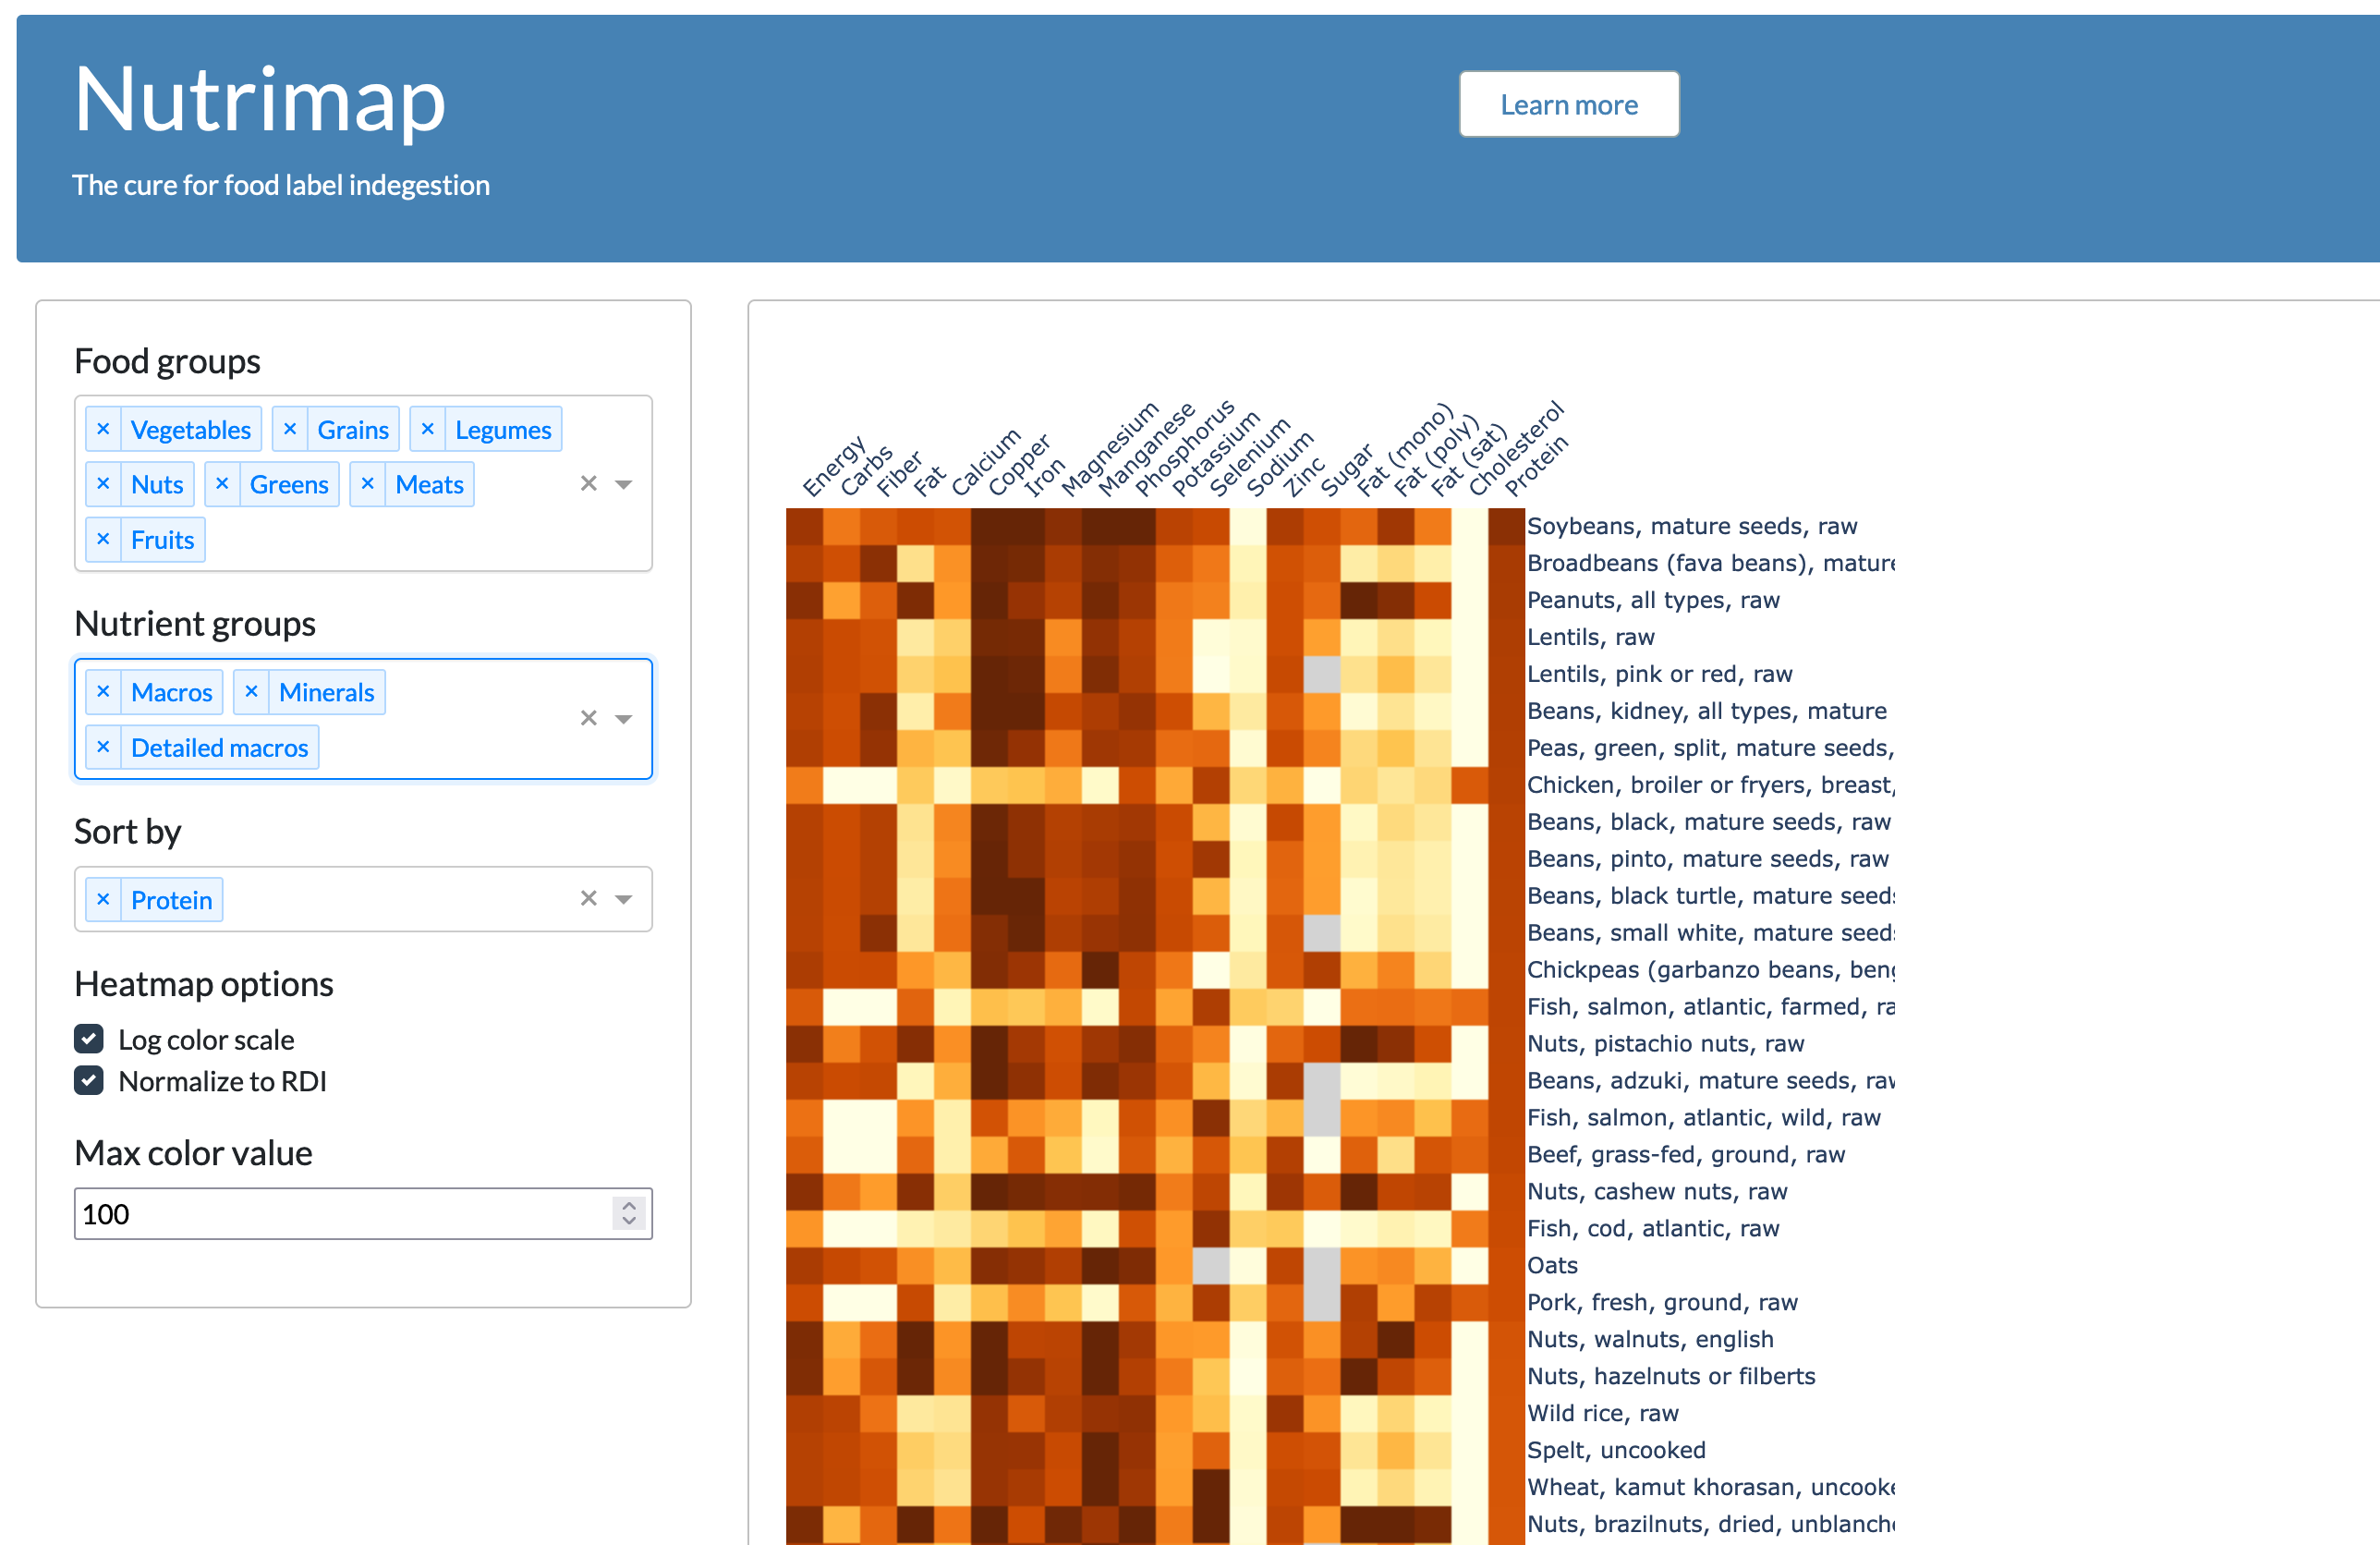

In [1]:
# import packages 
import pandas as pd
import altair as alt

In [2]:
# import data
foods = pd.read_csv('../data/processed/foods.csv', index_col = 0)

foods.head()

,Energy,Carbs,Protein,Fiber,Fat,Sugar,Fat (mono),Fat (poly),Fat (sat),Cholesterol,...,Threonine,Tryptophan,Tyrosine,Valine,Lycopene,Lutein + zeaxanthin,alpha-Carotene,beta-Carotene,beta-Cryptoxanthin,Vitamin K
food,,,,,,,,,,,,,,,,,,,,,
"Quinoa, uncooked",953.5,64.16,14.12,7.0,6.07,NaN,1.613,3.292,0.706,0.0,...,0.421,0.167,0.267,0.594,0.0,163.0,0.0,8.0,1.0,1.1
Oats,1008.5,66.27,16.89,10.6,6.90,NaN,2.178,2.535,1.217,0.0,...,0.575,0.234,0.573,0.937,NaN,NaN,NaN,NaN,NaN,NaN
"Barley, pearled, raw",912.5,77.72,9.91,15.6,1.16,0.80,0.149,0.560,0.244,0.0,...,0.337,0.165,0.284,0.486,0.0,160.0,0.0,13.0,0.0,NaN
Buckwheat,889.0,71.50,13.25,10.0,3.40,NaN,1.040,1.039,0.741,0.0,...,0.506,0.192,0.241,0.678,NaN,NaN,NaN,NaN,NaN,NaN
"Rice, brown, long-grain, raw",950.5,76.25,7.54,3.6,3.20,0.66,1.054,1.000,0.591,0.0,...,0.291,0.101,0.298,0.466,0.0,0.0,0.0,0.0,0.0,0.6


In [3]:
# get RDI values
rdis = pd.read_csv('../data/processed/matched_rdi_sr_nih.csv', comment='#')
def compute_rdi_proportion(row):
    '''Calculate the proportion of the RDI contained in each nutrient'''
    new_row = pd.Series(dtype=float)
    for col_name in row.index:
        nutrient_rdi = rdis.loc[rdis['MatchedNutrient'] == col_name, 'Amount'].values[0]
        rdi_proportion = round(100 * row[col_name] / nutrient_rdi, 3)
        # Round to 2 significant digits https://stackoverflow.com/a/48812729/2166823
        new_row.loc[col_name] = rdi_proportion # 
    return new_row

In [4]:
# compute RDI values
foods = foods.apply(compute_rdi_proportion, axis=1).reset_index()

foods.head(6)

,food,Energy,Carbs,Protein,Fiber,Fat,Sugar,Fat (mono),Fat (poly),Fat (sat),...,Threonine,Tryptophan,Tyrosine,Valine,Lycopene,Lutein + zeaxanthin,alpha-Carotene,beta-Carotene,beta-Cryptoxanthin,Vitamin K
0,"Quinoa, uncooked",43.341,32.080,25.214,18.421,9.338,NaN,7.332,14.964,3.530,...,30.071,47.714,23.117,35.357,0.0,1.358,0.0,0.178,0.333,0.917
1,Oats,45.841,33.135,30.161,27.895,10.615,NaN,9.900,11.523,6.085,...,41.071,66.857,49.610,55.774,NaN,NaN,NaN,NaN,NaN,NaN
2,"Barley, pearled, raw",41.477,38.860,17.696,41.053,1.785,3.20,0.677,2.545,1.220,...,24.071,47.143,24.589,28.929,0.0,1.333,0.0,0.289,0.000,NaN
3,Buckwheat,40.409,35.750,23.661,26.316,5.231,NaN,4.727,4.723,3.705,...,36.143,54.857,20.866,40.357,NaN,NaN,NaN,NaN,NaN,NaN
4,"Rice, brown, long-grain, raw",43.205,38.125,13.464,9.474,4.923,2.64,4.791,4.545,2.955,...,20.786,28.857,25.801,27.738,0.0,0.000,0.0,0.000,0.000,0.500
5,"Wild rice, raw",42.068,37.450,26.304,16.316,1.662,10.00,0.723,3.073,0.780,...,33.500,51.143,53.853,51.071,0.0,1.833,0.0,0.244,0.000,NaN


In [5]:
# pivot the data to long form
foods_long = pd.melt(foods,
                     id_vars = 'food',
                     value_vars = foods.columns.tolist()[1:],
                     ignore_index = False
                    ).rename(columns = {'variable':'nutrient'})

foods_long.head()

,food,nutrient,value
0,"Quinoa, uncooked",Energy,43.341
1,Oats,Energy,45.841
2,"Barley, pearled, raw",Energy,41.477
3,Buckwheat,Energy,40.409
4,"Rice, brown, long-grain, raw",Energy,43.205


In [6]:
food_groups = {
    # TODO add corn on the cob as veggie
    'grains': ['Quinoa, uncooked',  'Amaranth grain, uncooked', 'Oats', 'Barley, pearled, raw', 'Corn grain, yellow', 
               'Buckwheat', 'Rice, brown, long-grain, raw', 'Wild rice, raw',
               'Millet, raw', 'Bulgur, dry', 'Spelt, uncooked', 'Wheat, durum',
               'Wheat, hard red winter', 'Sorghum grain',
               'Wheat, kamut khorasan, uncooked',
               'Rice, white, long-grain, regular, raw, unenriched', 
               'Teff, uncooked', 'Rye grain'],
    'vegetables': ['Brussels sprouts, raw', 'Beets, raw', 'Broccoli, raw', 
                   'Cauliflower, raw', 'Eggplant, raw', 'Tomatoes, red, ripe, raw, year round average',
                   'Peas, green, frozen, unprepared'],
    'greens': ['Kale, raw', 'Spinach, raw', 'Lettuce, cos or romaine, raw',
               'Chard, swiss, raw', 'Arugula, raw', 'Collards, raw',
               'Lettuce, iceberg (includes crisphead types), raw', 'Beet greens, raw',
               'Mustard greens, raw', 'Cabbage, chinese (pak-choi), raw',
               'Cabbage, raw', ],
    'legumes': ['Beans, black turtle, mature seeds, raw', 'Lentils, raw',
                'Lentils, pink or red, raw', 'Beans, snap, green, raw',
                'Soybeans, green, raw', 'Beans, pinto, mature seeds, sprouted, raw',
                'Beans, adzuki, mature seeds, raw',
                'Beans, black, mature seeds, raw',
                'Beans, kidney, all types, mature seeds, raw',
                'Beans, pinto, mature seeds, raw',
                'Beans, small white, mature seeds, raw',
                'Soybeans, mature seeds, raw',
                'Broadbeans (fava beans), mature seeds, raw', 'Peas, green, raw',
                'Chickpeas (garbanzo beans, bengal gram), mature seeds, raw',
                'Peas, green, split, mature seeds, raw'],
    'nuts': [f'Nuts, {x.lower()}' for x in ['Brazilnuts, dried, unblanched',
             'Cashew nuts, raw',
             'Hazelnuts or filberts', 
             'Macadamia nuts, raw', 
             'Pine nuts, dried', 'Pistachio nuts, raw', 'Walnuts, english',
             'Coconut meat, dried (desiccated), not sweetened']] + ['Peanuts, all types, raw'],
    'fruits': ["Apples, raw, with skin",
               'Pineapple, raw, all varieties', 'Plums, raw', 'Pears, raw',
               'Apricots, raw', 'Avocados, raw, all commercial varieties',
               'Blackberries, frozen, unsweetened', 'Blueberries, raw',
               'Cranberries, raw', 'Raspberries, raw', 'Clementines, raw',
               'Strawberries, raw', 'Dates, medjool', 'Plantains, green, raw',
               'Pomegranates, raw', 'Bananas, raw', 'Plantains, yellow, raw',
               'Kiwifruit, green, raw', 'Figs, dried, uncooked', 'Oranges, raw, all commercial varieties',
               'Apricots, dried, sulfured, uncooked', 'Olives, ripe, canned (small-extra large)',
               'Raisins, dark, seedless'],
    'meats': ['Fish, salmon, atlantic, farmed, raw', 'Fish, salmon, atlantic, wild, raw',
              'Fish, cod, atlantic, raw', 'Chicken, broiler or fryers, breast, skinless, boneless, meat only, raw',
              'Pork, fresh, ground, raw',  'Beef, grass-fed, ground, raw', 'Egg, whole, raw, fresh', ]
}

nutrient_groups = dict(
    macros = [
        'Energy',
        'Carbs',
        'Protein',
        'Fiber',
        'Fat',
    ],

    detailed_macros =  [
        'Sugar',
        'Fat (mono)',
        'Fat (poly)',
        'Fat (sat)',
        'Cholesterol',
    ],

    minerals = [
        'Calcium',
        'Copper',
        'Iron',
        'Magnesium',
        'Manganese',
        'Phosphorus',
        'Potassium',
        'Selenium',
        'Sodium',
        'Zinc'
    ],

# TODO shorten names by removing "vitamin" and adding suffixes https://en.wikipedia.org/wiki/B_vitamins
        # add b1 k2 etc annotation
    vitamins = [
        'Thiamin (B1)',
        'Riboflavin (B2)',
        'Niacin (B3)',
        'Pantothenic acid (B5)',
        'Pyridoxine (B6)',
        'Folate (B9)',
        'Cobalmins (B12)',
        'Vitamin A',
        'Vitamin C',
        'Vitamin D (D2 + D3)',
        'Vitamin E',
        'Vitamin K',
        # 'Vitamin K (Dihydrophylloquinone)',
        # 'Vitamin K (Menaquinone-4)',
        # 'Vitamin K (phylloquinone)'
    ],

# eaas plus cysteine and tyrosine
    aas = [
        'Cystine',
        'Histidine',
        'Isoleucine',
        'Leucine',
        'Lysine',
        'Methionine',
        'Phenylalanine',
        'Threonine',
        'Tryptophan',
        'Tyrosine',
        'Valine',
    ],

    caretonoids = [
        'Lycopene',
        'Lutein + zeaxanthin',
        'alpha-Carotene',
        'beta-Carotene',
        # 'Retinol',
        'beta-Cryptoxanthin',
    ],
)

In [7]:
# code from https://towardsdatascience.com/how-to-build-a-time-series-dashboard-in-python-with-panel-altair-and-a-jupyter-notebook-c0ed40f02289

import panel as pn
alt.renderers.enable('default')
pn.extension('vega', sizing_mode="stretch_width")

# widgets needed:
# - selectable food groups
# - selectable nutrient groups
# - sort by dropdown or selector
# - selectable max color value

In [8]:
# add checkbuttongroup for food groups
food_group = pn.widgets.CheckButtonGroup(name='Food Groups', 
                                                value=['grains'], # currently selected
                                                options=food_groups # options
                                               )

food_group

CheckButtonGroup(name='Food Groups', options={'grains': ['Quinoa, ...}, sizing_mode='stretch_width')

In [9]:
# add checkbuttongroup for nutrient groups
nutrient_group = pn.widgets.CheckButtonGroup(name='Nutrient Groups', 
                                                value=['macros'], 
                                                options=nutrient_groups
                                               )

nutrient_group

CheckButtonGroup(name='Nutrient Groups', options={'macros': ['Energy', ...}, sizing_mode='stretch_width')

In [10]:
# add slider to set maximum DV value, affecting max value of heatmap color range
color_slider = pn.widgets.DiscreteSlider(name = 'Maximum Daily Value',
                                            options = [i for i in range(int(min(foods_long['value'])), 
                                                            int(max(foods_long['value'])))],
                                            value = 300
                                           )

color_slider

DiscreteSlider(formatter='%d', name='Maximum Daily Value', options=[0, 1, 2, 3, 4, ...], sizing_mode='stretch_width', value=300)

In [11]:
# flatten list of food/nutrient groups selected in widget
def get_selected(values):
    names = []
    for group in values:
        for i in group:
            names.append(i)
    return names

In [30]:
# tell panel to reload chart when parameters change
@pn.depends(food_group.param.value, nutrient_group.param.value, color_slider.param.value)

def make_plot(food_group, nutrient_group, color_slider):     
    # Load the data
    df = foods_long # define df
    df.loc[df['value'] > color_slider, 'value'] = color_slider
    # filter data according to selectors
    mask = (df['food'].isin(get_selected(food_group)) & (df['nutrient'].isin(get_selected(nutrient_group))))
    df = df.loc[mask] # filter the dataframe     
    # create the Altair chart object
    chart = alt.Chart(df).mark_rect().encode(
        x = alt.X('nutrient', axis=alt.Axis(title = 'Nutrient')),
        y = alt.Y('food', axis=alt.Axis(title = 'Food')),
        color = alt.Color('value', legend=alt.Legend(title="Percent of Daily Value")),      
        tooltip=alt.Tooltip(['food:O', 'nutrient:O', 'value:Q']
                           )).properties(
            height = 800,
            width = 600                                      
    ).configure_axisY(
        orient = 'right'
    ).configure_axisX(
        orient = 'top',
        labelAngle = -45
    )
    return chart

In [31]:
# build the dashboard
nutrimap = pn.template.FastListTemplate(site='Nutrimap', title='A cure for food label indigestion',
                                       sidebar=[pn.pane.Markdown("## Settings"),
                                               food_group,
                                               nutrient_group,
                                               color_slider],
                                       main=[make_plot]).servable()

nutrimap

# note: rendering doesn't work correctly in notebook. Render using panel serve in terminal.

/opt/anaconda3/envs/nutrimap/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


FastListTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [140486919316928] ParamFunction(function, sizing_mode='stretch_width')
    [140486919309536] Markdown(str, sizing_mode='stretch_width')
    [140487335918032] CheckButtonGroup(name='Food Groups', options={'grains': ['Quinoa, ...}, sizing_mode='stretch_width', value=[['Quinoa, uncooked', ...])
    [140487336543904] CheckButtonGroup(name='Nutrient Groups', options={'macros': ['Energy', ...}, sizing_mode='stretch_width', value=[['Sugar', 'Fat (mono)', ...])
    [140487336547840] DiscreteSlider(formatter='%d', name='Maximum Daily Value', options=[0, 1, 2, 3, 4, ...], sizing_mode='stretch_width', value=300)